## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
from torch.nn.modules.activation import LogSoftmax
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
       BatchNorm1d-6                  [-1, 256]             512
           Dropout-7                  [-1, 256]               0
            Linear-8                  [-1, 128]          32,896
           Dropout-9                  [-1, 128]               0
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 64]           8,256
          Dropout-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
       LogSoftmax-14                   

Your experiments come here:

In [68]:
model = TinyNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

In [58]:
# Your experiments, training and validation loops here
def train(model, trainloader, validloader, opt, loss_func):
    valid_loss_min = np.Inf
    epochs = 40

    
    train_losses, valid_losses = [],[]
    for e in range(epochs):
      train_loss = 0 
      valid_loss = 0

      model.train(True)
      for images, labels in trainloader:

        opt.zero_grad()
        log_ps = model(images.to(device))
        loss = loss_func(log_ps, labels.to(device))
        loss.backward()
        opt.step()
        train_loss += loss.item()*images.to(device).size(0)
      
      model.train(False)
      for images, labels in validloader:
        log_ps = model(images.to(device))
        loss = loss_func(log_ps, labels.to(device))
        valid_loss += loss.item()*images.to(device).size(0)

      train_loss = train_loss/len(trainloader.sampler)
      valid_loss =  valid_loss/len(validloader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print(f'Epoch: {e+1} \tTraining Loss: {train_loss} \tValidation Loss: {valid_loss}')
      if valid_loss <= valid_loss_min:
          print(f'validation loss decreased({valid_loss_min} -->{valid_loss}). Saving Model ...')
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss

    return train_losses, valid_losses

In [69]:
train_losses, valid_losses = train(model, train_loader, test_loader, opt, loss_func)

Epoch: 1 	Training Loss: 0.6114594690322877 	Validation Loss: 0.42295369396209714
validation loss decreased(inf -->0.42295369396209714). Saving Model ...
Epoch: 2 	Training Loss: 0.424307491572698 	Validation Loss: 0.3935461939573288
validation loss decreased(0.42295369396209714 -->0.3935461939573288). Saving Model ...
Epoch: 3 	Training Loss: 0.3898337890942891 	Validation Loss: 0.38149892036914823
validation loss decreased(0.3935461939573288 -->0.38149892036914823). Saving Model ...
Epoch: 4 	Training Loss: 0.3692462565898895 	Validation Loss: 0.36477113378047943
validation loss decreased(0.38149892036914823 -->0.36477113378047943). Saving Model ...
Epoch: 5 	Training Loss: 0.35335672483444214 	Validation Loss: 0.36738752932548524
Epoch: 6 	Training Loss: 0.34159773619969686 	Validation Loss: 0.37560870044231415
Epoch: 7 	Training Loss: 0.32768761785825096 	Validation Loss: 0.3433255675435066
validation loss decreased(0.36477113378047943 -->0.3433255675435066). Saving Model ...
Epoch

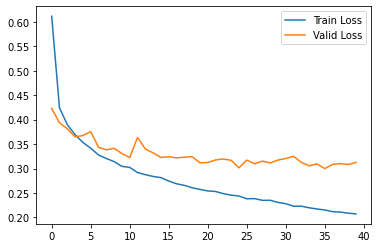

In [70]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()

In [71]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [72]:
def eval(model, testloader, loss_func):
    test_loss = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()
    for images, labels in testloader:
      output = model(images.to(device))
      loss = loss_func(output, labels.to(device))
      test_loss += loss.item()*images.to(device).size(0)
      _, pred = torch.max(output, 1)
      correct = np.squeeze(pred.eq(labels.to(device).data.view_as(pred)))

      for i in range(len(labels.to(device))):
        label = labels.to(device).data[i]
        class_correct[label] += correct[i].item()
        class_total[label] +=1

    test_loss = test_loss/len(testloader.sampler)
    print(f'Test Loss: {test_loss}\n')

    for i in range(10):
      print(f'Test Accuracy of {i} class: {100 * class_correct[i]/class_total[i]}% ({np.sum(class_correct[i])}/{np.sum(class_total[i])})')

    print(f'\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total)}% ({np.sum(class_correct)}/{np.sum(class_total)})')


In [73]:
eval(model, test_loader, loss_func)

Test Loss: 0.2998658456325531

Test Accuracy of 0 class: 87.7% (877.0/1000.0)
Test Accuracy of 1 class: 97.7% (977.0/1000.0)
Test Accuracy of 2 class: 80.5% (805.0/1000.0)
Test Accuracy of 3 class: 90.4% (904.0/1000.0)
Test Accuracy of 4 class: 81.2% (812.0/1000.0)
Test Accuracy of 5 class: 97.2% (972.0/1000.0)
Test Accuracy of 6 class: 71.1% (711.0/1000.0)
Test Accuracy of 7 class: 95.5% (955.0/1000.0)
Test Accuracy of 8 class: 98.0% (980.0/1000.0)
Test Accuracy of 9 class: 96.7% (967.0/1000.0)

Test Accuracy (Overall): 89.6% (8960.0/10000.0)


Таким образом, применяя только линейные слои, функции активаци, Dropout и BatchNorm получили требуемую accuracy на тестовой выборке. А именно, accuracy равна 89.6%

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [63]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.Linear(512, 64),
            nn.Tanh(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [64]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
            Linear-3                   [-1, 64]          32,832
              Tanh-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
Total params: 435,402
Trainable params: 435,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.66
Estimated Total Size (MB): 1.67
----------------------------------------------------------------


In [65]:
model = OverfittingNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [66]:
train_losses, valid_losses = train(model, train_loader, test_loader, opt, loss_func)

Epoch: 1 	Training Loss: 0.6825458422342936 	Validation Loss: 0.4992319903373718
validation loss decreased(inf -->0.4992319903373718). Saving Model ...
Epoch: 2 	Training Loss: 0.4410991883913676 	Validation Loss: 0.44210348176956177
validation loss decreased(0.4992319903373718 -->0.44210348176956177). Saving Model ...
Epoch: 3 	Training Loss: 0.39857101678848267 	Validation Loss: 0.4204574234008789
validation loss decreased(0.44210348176956177 -->0.4204574234008789). Saving Model ...
Epoch: 4 	Training Loss: 0.37698430991172793 	Validation Loss: 0.41473491101264953
validation loss decreased(0.4204574234008789 -->0.41473491101264953). Saving Model ...
Epoch: 5 	Training Loss: 0.36162529945373534 	Validation Loss: 0.4006337685108185
validation loss decreased(0.41473491101264953 -->0.4006337685108185). Saving Model ...
Epoch: 6 	Training Loss: 0.3475275408903758 	Validation Loss: 0.3905037955760956
validation loss decreased(0.4006337685108185 -->0.3905037955760956). Saving Model ...
Epoc

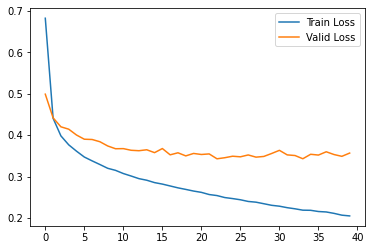

In [67]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()

По истории обучения модели видно, что последние 16 эпох модель не улучшала loss. По графику можно заметить, что значения функции потерь на валидационной выборке вышли на плато, в то время, как значения функции потерь на обучающей выборке продолжают заметно снижаться.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [78]:
from torch.nn.modules.batchnorm import BatchNorm1d
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.Dropout(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 64),
            nn.Tanh(),
            nn.Dropout(),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [79]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
           Dropout-3                  [-1, 512]               0
       BatchNorm1d-4                  [-1, 512]           1,024
            Linear-5                   [-1, 64]          32,832
              Tanh-6                   [-1, 64]               0
           Dropout-7                   [-1, 64]               0
       BatchNorm1d-8                   [-1, 64]             128
            Linear-9                   [-1, 10]             650
Total params: 436,554
Trainable params: 436,554
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.67
Estimated Total Size (MB): 1.69
-------------------------------------------

In [80]:
model = FixedNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [81]:
train_losses, valid_losses = train(model, train_loader, test_loader, opt, loss_func)

Epoch: 1 	Training Loss: 0.7807825310230255 	Validation Loss: 0.5128913924694062
validation loss decreased(inf -->0.5128913924694062). Saving Model ...
Epoch: 2 	Training Loss: 0.5466785126368204 	Validation Loss: 0.4759325921535492
validation loss decreased(0.5128913924694062 -->0.4759325921535492). Saving Model ...
Epoch: 3 	Training Loss: 0.510222056166331 	Validation Loss: 0.45152393975257876
validation loss decreased(0.4759325921535492 -->0.45152393975257876). Saving Model ...
Epoch: 4 	Training Loss: 0.4894697704950968 	Validation Loss: 0.44219344334602356
validation loss decreased(0.45152393975257876 -->0.44219344334602356). Saving Model ...
Epoch: 5 	Training Loss: 0.47675726280212405 	Validation Loss: 0.43666261324882505
validation loss decreased(0.44219344334602356 -->0.43666261324882505). Saving Model ...
Epoch: 6 	Training Loss: 0.46827791078885395 	Validation Loss: 0.44064494285583494
Epoch: 7 	Training Loss: 0.4587136237780253 	Validation Loss: 0.420996710729599
validatio

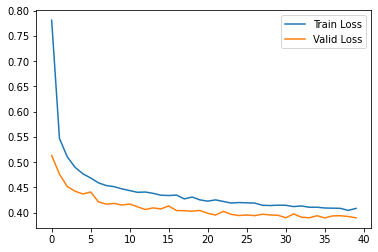

In [82]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()

In [83]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [84]:
eval(model, test_loader, loss_func)

Test Loss: 0.3893064631462097

Test Accuracy of 0 class: 82.5% (825.0/1000.0)
Test Accuracy of 1 class: 95.8% (958.0/1000.0)
Test Accuracy of 2 class: 78.7% (787.0/1000.0)
Test Accuracy of 3 class: 88.3% (883.0/1000.0)
Test Accuracy of 4 class: 80.2% (802.0/1000.0)
Test Accuracy of 5 class: 93.5% (935.0/1000.0)
Test Accuracy of 6 class: 56.1% (561.0/1000.0)
Test Accuracy of 7 class: 94.5% (945.0/1000.0)
Test Accuracy of 8 class: 96.8% (968.0/1000.0)
Test Accuracy of 9 class: 94.2% (942.0/1000.0)

Test Accuracy (Overall): 86.06% (8606.0/10000.0)


### Conclusions:
_Write down small report with your conclusions and your ideas._



*   В первом пункте работы была получена сеть, которая удовлетворяет поставленной задаче и выдаёт accuracy 89.6% на тестовой выборке. 
При этом в приведённой архитектуре намеренно не используются свёрточные слои. Их использование, скорее всего, позволит ещё более улучшить качество модели.
*   В следующем пункте задания получилось намеренно несколько переобучить модель, а затем исправить переобучение, добавив в архитектуру сети Dropout и BatchNorm слои.
*   Точность исправленной модели получилась не очень высокая, 86.06% на тестовой выборке, так как архитектура не самая удачная. Но зато по графику обучения видно, что функции потерь на обучающей и на теестовой выборке совместно снижаются, что говорит о том, что модель перестала переобучаться. И этого удалось добиться только внедрением Dropout и BatchNorm слоев.


